In [15]:
import pickle, os, sys
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

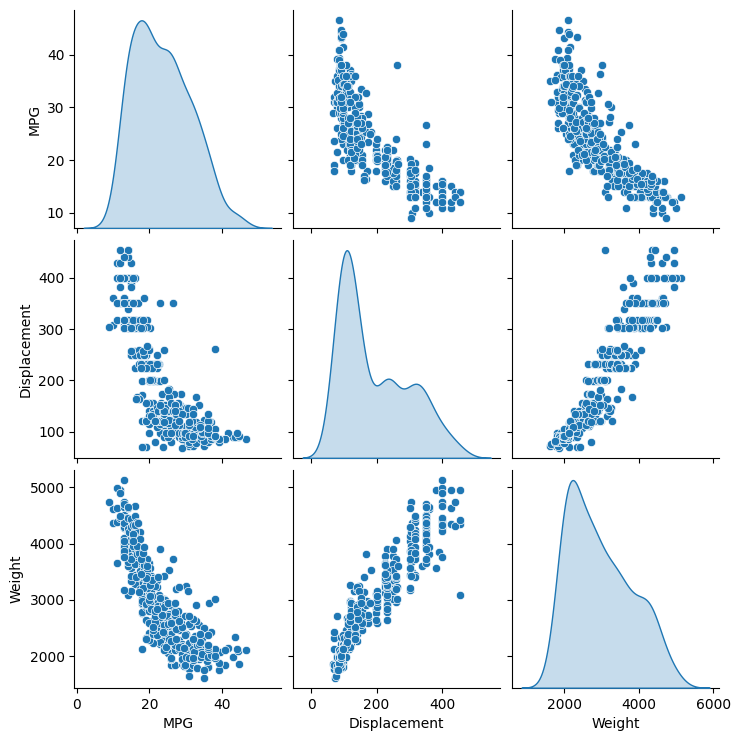

In [16]:
# TRAIN PIPELINE

# READ DF
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
df = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)
sns.pairplot(df[['MPG', 'Displacement', 'Weight']], diag_kind='kde')


c:\Users\oliver.koehn\Documents\gitProjects\dataAndAiExamples\venv312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


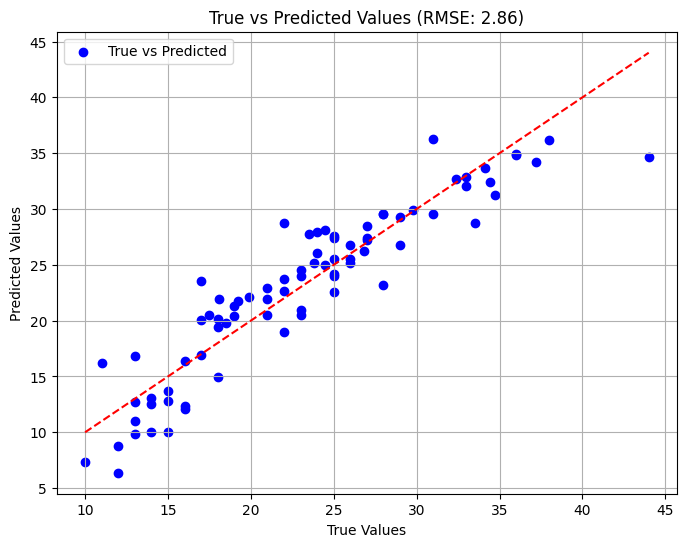

In [17]:
# INITIALIZE
metr = {}
pipeline = {}
tar_col = "MPG"

X = df.drop(columns=[tar_col])  # Features
y = df[tar_col]  # Target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define numerical and categorical column names
numerical_cols = [col for col, dtype in df.dtypes.items() if not(dtype == "object") and not (col == tar_col)]  # Replace with actual numerical column names
categorical_cols = [col for col, dtype in df.dtypes.items() if (dtype == "object") and not (col == tar_col)]  # Replace with actual categorical column names

# Impute missing values
numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Update the preprocessing steps for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', numerical_imputer),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', categorical_imputer),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps for both numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

#########################################################################
#########################FIT############################################
#########################################################################

regression_method = LinearRegression() # RandomForestRegressor, MLPRegressor
# Update the pipeline with the new preprocessing steps
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', regression_method)])

pipeline.fit(X_train, y_train)


#########################################################################
#########################PERFOMANCE############################################
#########################################################################
# Make predictions on the testing data
predictions = pipeline.predict(X_test)

metr = {}
metr["r2"] = r2_score(y_test, predictions)
metr["mse"] = mean_squared_error(y_test, predictions)
metr["rmse"] = mean_squared_error(y_test, predictions, squared=False)
metr["mae"] = mean_absolute_error(y_test, predictions)
metr["nmse"] = mean_squared_error(y_test, predictions) / (y_test.max() - y_test.min())
metr["y_test"] = y_test
metr["predictions"] = predictions

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_test, predictions, color='blue', label='True vs Predicted')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')
ax.set_title(f"True vs Predicted Values (RMSE: {metr['rmse']:.2f})")
ax.legend(loc='best')
ax.grid(True)

print(f"")

In [18]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
Cylinders,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
Displacement,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
Horsepower,392.0,104.469388,38.491160,46.0,75.000,93.5,126.000,230.0
Weight,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
Acceleration,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
Model Year,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
Origin,398.0,1.572864,0.802055,1.0,1.000,1.0,2.000,3.0


In [19]:
X_tr = pd.DataFrame(preprocessor.fit_transform(df))
X_tr.columns = X.columns
X_tr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Cylinders,398.0,-3.570567e-17,1.001259,-1.444949,-0.856321,-0.856321,1.498191,1.498191
Displacement,398.0,-1.785283e-17,1.001259,-1.204411,-0.856318,-0.431404,0.658488,2.511784
Horsepower,398.0,1.785283e-16,1.001259,-1.532571,-0.746226,-0.248207,0.538138,3.290348
Weight,398.0,-1.606755e-16,1.001259,-1.604943,-0.882827,-0.197362,0.753834,2.565185
Acceleration,398.0,-2.677925e-16,1.001259,-2.747814,-0.632879,-0.024722,0.583435,3.351912
Model Year,398.0,-1.642461e-15,1.001259,-1.627426,-0.815074,-0.002721,0.809631,1.621983
Origin,398.0,-5.355850e-17,1.001259,-0.715145,-0.715145,-0.715145,0.533222,1.781589


In [20]:
# SAVE PIPELINE
j_pipeline = {"pipeline" : pipeline}
with open(os.path.join("out", "savedRegPipeline.pkl"), "wb") as f:
    pickle.dump(j_pipeline, f)

In [21]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
df = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)

df.to_excel(os.path.join("in", "autoMpg.xlsx"), index=False)

In [22]:
# LOAD PIPELINE AND TEST
import pandas as pd
import pickle, os
import numpy as np
# read data
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
df = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)
df = pd.read_excel(os.path.join("in", "autoMpg.xlsx"))

# load pipeline
with open(os.path.join("out", "savedRegPipeline.pkl"), "rb") as f:
    j_pipeline = pickle.load(f)
pipeline = j_pipeline["pipeline"]

# predict values
y_pred = pipeline.predict(df)

In [23]:
y_tar = df["MPG"].to_numpy()
squared_errors = (y_tar - y_pred) ** 2
mean_squared_error = np.mean(squared_errors)
rmse = np.sqrt(mean_squared_error)

print(f"RMSE: {rmse}")

RMSE: 3.3093824776348026
